In [850]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [997]:
#Read in surface stats
db = pickle.load(open('workspace/SFstats.pck','rb'))
#Read in LES output
file = 'workspace/LESoutput.pck'
les_db = pickle.load(open(file,'rb'))

In [998]:
#Assemble metrics
metrics = {}
dates =[]
eps = 10**-10
for var in ['TKE','LWP']:
 metrics[var] = []
 #Perform analysis at each date
 for date in les_db:
     if var == 'TKE':dates.append(datetime.datetime.strptime(date,'%Y-%m-%d'))
     hmg = les_db[date]['HMG'][var]
     htg = les_db[date]['HTG'][var]    
     if (np.sum(hmg != -9999) >= 90) & (np.sum(htg != -9999) >= 90):
         m2 = (htg != -9999) & (hmg != -9999)
         metrics[var].append(np.mean(htg[m2]-hmg[m2]))
         #if var == 'TKE':
         # plt.title(np.mean(htg[m2]-hmg[m2]))
          #plt.plot(hmg[m2])
          #plt.plot(htg[m2])
          #plt.show()
         #metrics[var].append(np.mean(htg[m2]-hmg[m2]))
         #metrics[var].append(np.mean(htg[m2])-np.mean(hmg[m2]))
         #metrics[var].append(np.mean(np.log2(htg[m2]+eps)-np.log2(hmg[m2]+eps)))
     else:
         metrics[var].append(-9999)
 metrics[var] = np.array(metrics[var])
 m = metric != -9999
dates = np.array(dates)

In [999]:
db['sh_L0_0.75'][:,0].shape

(43,)

0.6407090370064942


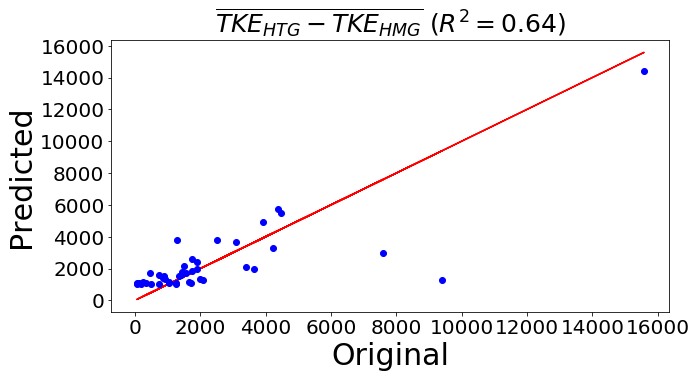

In [1131]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
import sklearn.metrics
var = 'TKE'
metric = metrics[var]
m2 = m #& (metrics['TKE'] < 5000)
v = 'sh_L0_0.75'
L0_0_3 = np.mean(db[v][:,0:3],axis=1)[m2]
L0_3_6 = np.mean(db[v][:,3:6],axis=1)[m2]
L0_6_10 = np.mean(db[v][:,6:10],axis=1)[m2]
L0_all = np.mean(db[v][:,0:10],axis=1)[m2]
ws = np.mean(db['ws'][:,ss],axis=1)[m2]
X = np.array([L0_0_3**2,L0_6_10**2,]).T
y = metric[m2]
regr = LinearRegression().fit(X, y)
ypred = regr.predict(X)
print(sklearn.metrics.explained_variance_score(y,ypred))
plt.figure(figsize=(10,5))
plt.plot(y,y,'r')
plt.plot(y,ypred,'bo')
plt.xlabel('Original',fontsize=30)
plt.ylabel('Predicted',fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
if var == 'TKE':
 plt.title(r'$\overline{TKE_{HTG} - TKE_{HMG}}$ ($R^2 = %.2f$)' % sklearn.metrics.explained_variance_score(y,ypred),fontsize=25)
else:
 plt.title(r'$\overline{LWP_{HTG} - LWP_{HMG}}$ ($R^2 = %.2f$)' % sklearn.metrics.explained_variance_score(y,ypred),fontsize=25)
plt.show()

In [1132]:
import sklearn.model_selection
clf = LinearRegression()
#clf = RandomForestRegressor(max_depth=2,n_estimators=250)
#clf = GradientBoostingRegressor(max_depth=2,n_estimators=250)
scores = sklearn.model_selection.cross_val_score(clf,X,y,cv=2,scoring='explained_variance')
print(np.mean(scores))
scores = sklearn.model_selection.cross_val_score(clf,X,y,cv=2,scoring='r2')
#scores = sklearn.model_selection.cross_val_score(clf,X,y,cv=2,scoring='neg_mean_squared_error')
print(np.mean(scores))

0.5625979813688258
0.5337906711633011


In [1133]:
import scipy.stats

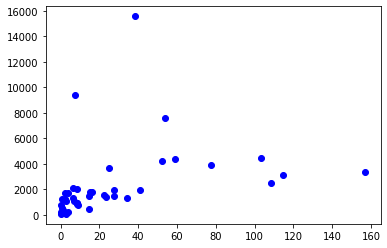

In [1135]:
plt.plot(L0_3_6**2,metrics['TKE'][m2],'bo')
#print(scipy.stats.pearsonr(np.log10(db[var][m2]),np.log10(metrics['TKE'][m2])))
#print(scipy.stats.pearsonr(db[var][m2]/db['ws'][m2],metrics['TKE'][m2]))

In [617]:
dates[metric > 7000]

array([datetime.datetime(2017, 6, 27, 0, 0),
       datetime.datetime(2016, 5, 30, 0, 0),
       datetime.datetime(2016, 8, 19, 0, 0)], dtype=object)

In [620]:
def Process_sounding_data(dates):

 db = {}
 db['ws'] = []
 db['theta'] = []
 for date in dates:
    print(date)
    file = '/stor/soteria/hydro/shared/lasso_for_nate/lasso_download/sgp%d%02d%02d/config/input_sounding' % (date.year,date.month,date.day)
    data = np.loadtxt(file,skiprows=1)
    z = data[:,0]
    dz = z[1:]-z[:-1]
    iz = (z[1:] >= 0) & (z[1:] <= 20000)#20000)
    zav = (z[1:] + z[1:])/2
    f = dz[iz]/np.sum(dz[iz])
    u = ((data[1:,-2] + data[0:-1,-2])/2)[iz]
    v = ((data[1:,-1] + data[0:-1,-1])/2)[iz]
    ug = np.sum(f*u)
    vg = np.abs(np.sum(f*v))
    ws = (u**2 + v**2)**0.5
    theta = np.arctan2(np.abs(v),u)
    f = ws/np.sum(ws)
    plt.plot(u,zav[iz])
    plt.plot(v,zav[iz])
    plt.legend(['u','v'])
    plt.show()
    #plt.subplot(121)
    #plt.title('WS')
    #lt.plot(ws,av[iz])
    #plt.subplot(122)
    #plt.title('Theta (degrees)')
    #plt.plot(np.degrees(theta),zav[iz])
    #plt.show()
    #Calculate magnitude
    #db['ws'].append((ug**2 + vg**2)**0.5)
    #db['theta'].append(np.arctan2(vg,ug)) #only 0-180 degrees (on purpose)
    print(date,(ug**2+vg**2)**0.5,np.degrees(np.arctan2(vg,ug)))
    ws_ta = np.sum(f*ws)
    theta_ta = np.sum(f*theta)
    print(date,ws_ta,np.degrees(theta_ta))
 for var in db:
    db[var] = np.array(db[var])
 #Save the data
 file = 'workspace/LASSOsoundings.pck'
 pickle.dump(db,open(file,'wb'))

2017-06-27 00:00:00


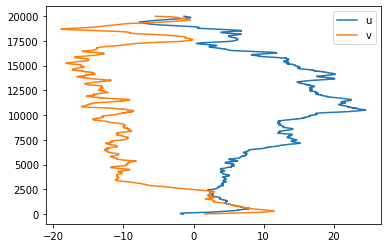

2017-06-27 00:00:00 13.405373436546455 43.52683465814736
2017-06-27 00:00:00 18.006645503258206 47.32664538279365
2016-05-30 00:00:00


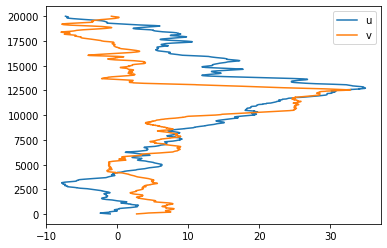

2016-05-30 00:00:00 10.701810253617854 32.61973340852796
2016-05-30 00:00:00 21.30108553189258 42.432577541114284
2016-08-19 00:00:00


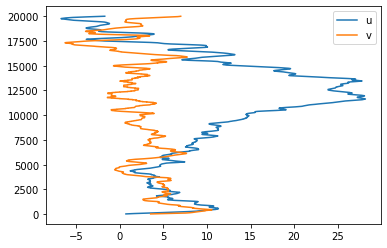

2016-08-19 00:00:00 10.460519372866871 13.945376588293378
2016-08-19 00:00:00 16.279011274296593 19.74966688923134


In [623]:
Process_sounding_data(dates[metric > 7000])

In [380]:
dbs = pickle.load(open('workspace/LASSOsoundings.pck','rb'))

In [386]:
np.degrees(dbs['theta'])

array([ 63.9220321 ,  39.44888917,  48.25723729,   8.75726517,
        69.48933263, -37.84661685,  25.81060496,  65.56051266,
        57.73751809,  43.86790714,  66.2336309 ,  56.63235443,
        30.15301136,  57.38859466,  14.2043329 ,  -8.67222321,
       -16.44418333, -11.75379165,   0.58703841,   2.04583697,
         5.19945537,  13.33210649,  53.88862347,  48.44996006,
        61.5042914 ,   8.80548087,   7.07803624,  32.47104313,
         6.96374824,   5.85774419,  58.22242269,  31.49578509,
        30.87528935,  18.43047276,  63.37455738, -49.1864483 ,
        28.52920974,  33.22491191, -21.93591644,   9.92919527,
        23.74775243,  65.45023546,  10.85441498])

In [842]:
import netCDF4 as nc
date = '20170627'
file = '/stor/soteria/hydro/shared/lasso_for_nate/doz_uvtrim_00/uvtrim_%s.nc' % date
fp = nc.Dataset(file)
file = '/stor/soteria/hydro/shared/lasso_for_nate/doz_uvtrim_01/uvtrim_%s.nc' % date
fp2 = nc.Dataset(file)

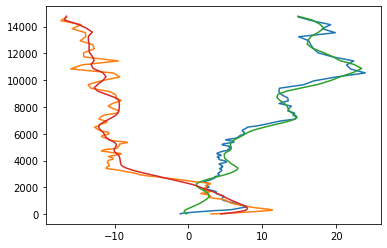

[   15.915601    47.722893    79.441574   111.03878    142.5414
   173.97195    205.36198    236.71957    268.03912    299.33942
   330.61548    361.8685     393.10022    424.3059     455.48813
   486.6482     517.79364    548.9284     580.0519     611.16113
   642.2577     673.3456     704.42487    735.495      766.54974
   797.58466    828.6037     859.61066    890.60693    921.5988
   952.58936    983.5775    1014.5612    1045.5378    1076.5073
  1107.4663    1138.4137    1169.345     1200.2626    1231.1726
  1262.0668    1292.9426    1323.8057    1354.6545    1385.4893
  1416.3137    1447.1326    1477.948     1508.759     1539.5627
  1570.3577    1601.1418    1631.9153    1662.6754    1693.4268
  1724.1764    1754.9232    1785.6664    1816.4       1847.1218
  1877.8363    1908.5381    1939.2249    1969.9011    2000.5715
  2031.2434    2061.9146    2092.583     2123.2554    2153.932
  2184.6138    2215.2996    2245.989     2276.6794    2307.3726
  2338.0684    2368.7664    2399.4607

In [849]:
it = 70
z = fp['z'][1,:]
u = fp['u'][1,:]
v = fp['v'][1,:]
plt.plot(u,z)
plt.plot(v,z)
z = fp['z'][it,:]
u = fp['u'][it,:]
v = fp['v'][it,:]
plt.plot(u,z)
plt.plot(v,z)
plt.show()
print(z)